# 项目2：量子电路编译算法

对于任意一个目标量子电路，需要通过路由映射才能在实际量子计算机上执行。在超导量子芯片上，qubits之间不是俩俩相连的。而比特若不直接相连，则无法直接做两比特门



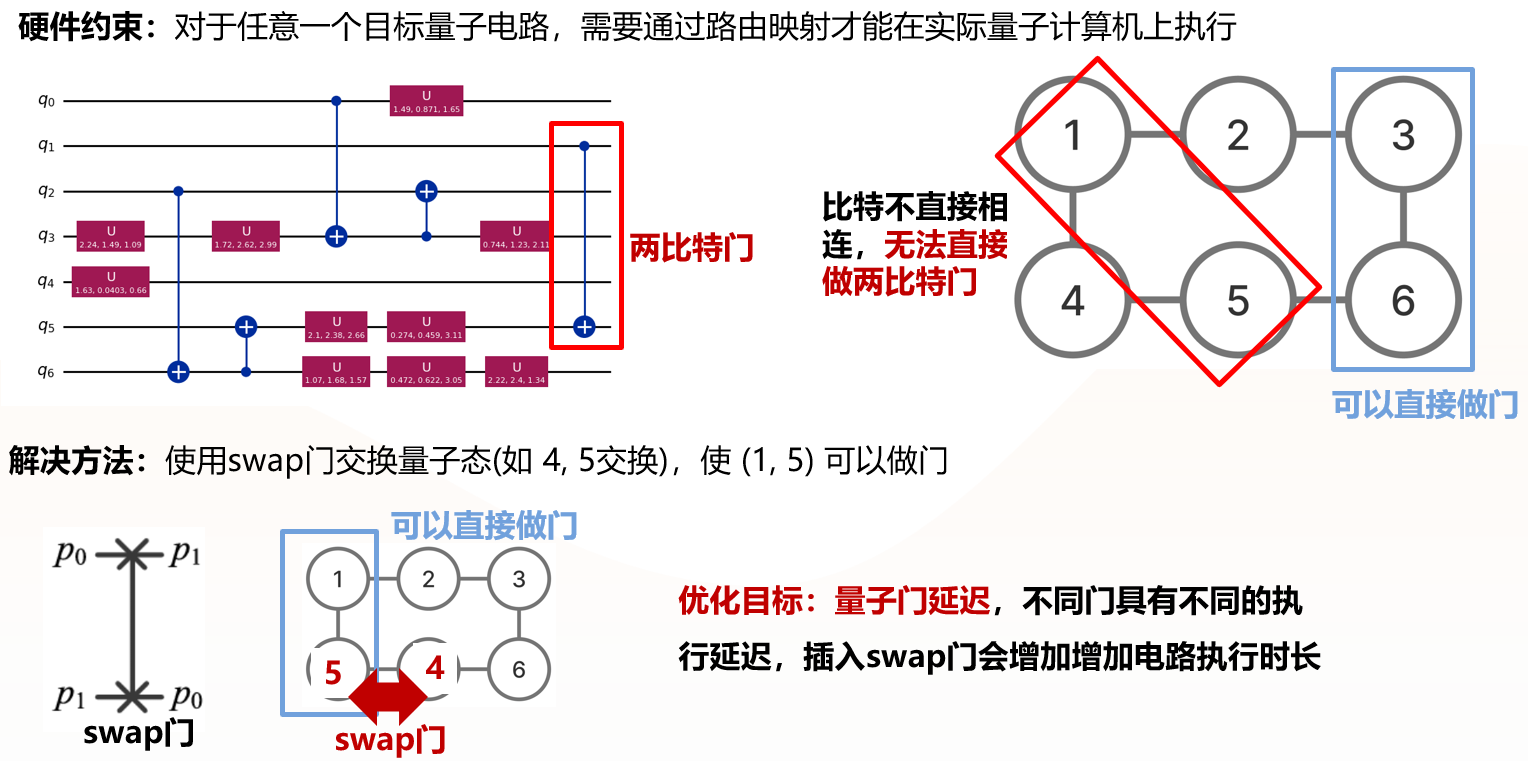

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from routing_lib import Q_circuit

首先，我们选取2号测试电路作为演示。一共有1-6六个测试电路可供测试和使用。所有测试电路都只包含CZ门和U门

每个电路都直接分配了相应的硬件结构，全都是矩形格点结构，具体可以看函数定义。

In [11]:
qc = Q_circuit()
qc.load_test(2)

下图是该电路的图像。

整张图的逻辑是，从左往右表示时间序列，纵向每行代表一个qubit在整个时间线上的状态。

其中，绿色的是单比特门，持续时间比较短，只作用于一个qubit；

蓝色和红色代表双比特门，同时作用在两个qubit上，持续时间稍长。只有比特相邻的双比特门才是蓝色，其余都是红色；

还有灰色的SWAP门，它的时间更长，下面会出现。

这个绘图function有助于你测试自己的routing结果

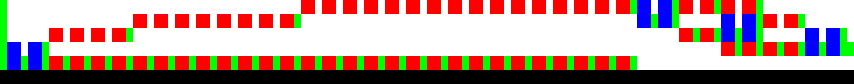

In [12]:
img = qc.plot_circuit(7) # 参数是图像缩放

## 任务 1：完成routing()函数

你需要完成下面这个现在没用的routing函数。你需要通过添加swap门让原电路里的双比特门都只在直接相连的物理比特上应用，这样才代表该电路实际上是能跑的。

同时，你需要让电路在routing后尽量短，你需要找到尽量最优的swap添加方式

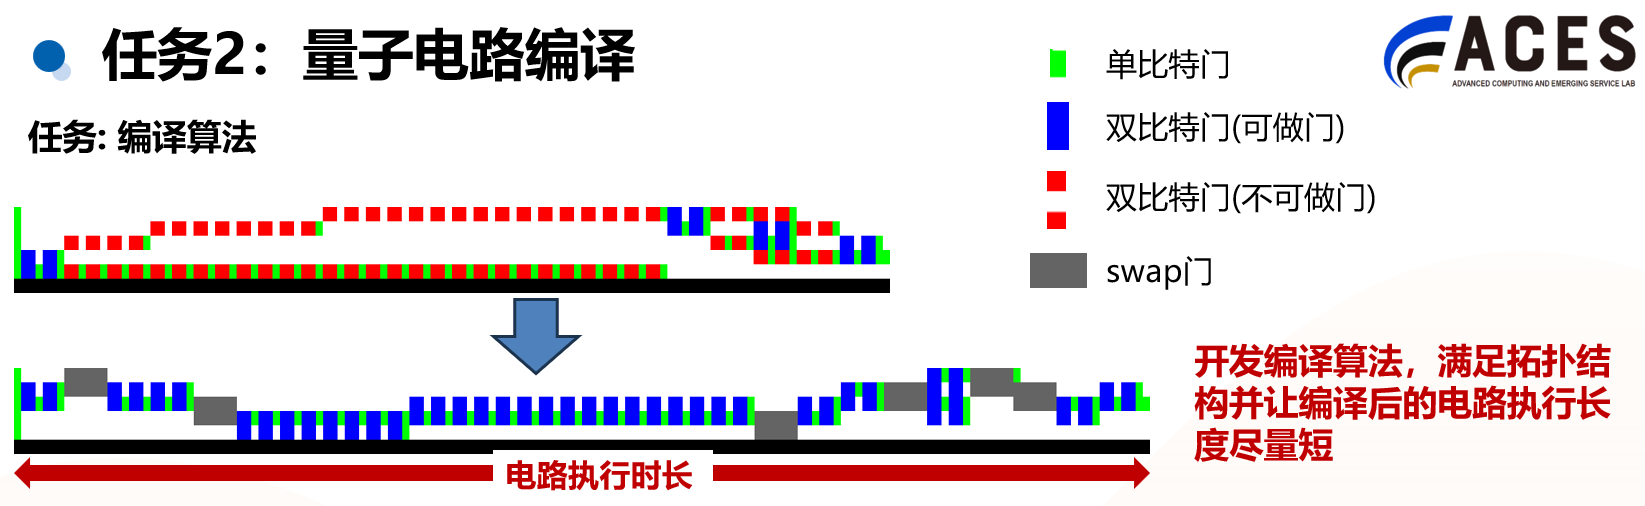

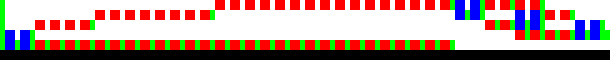

In [13]:
qc.routing()  # 你需要完成的部分
img = qc.plot_circuit() #缩放大小默认是5

下面是调用qiskit库得到的routing后结果。

可以看到，通过添加SWAP门(灰块)，所有的双比特门都变成了合法的(蓝色)

这是任务一的目标，qiskit的结果可供参考

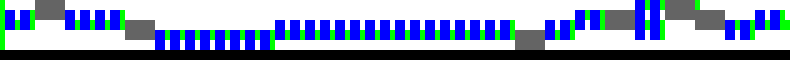

In [14]:
qc.mpping_by_qiskit()
img = qc.plot_circuit()

在routing完毕后，调用以下函数计算电路保真度。一般来说，结果电路越短，保真度越高。

qc.fed_logi_list里有每个qubit的具体保真度结果，可以使用以下代码来绘图。

需要注意的是，list1和list2都是排序过后的结果，因此实际qubit位置不一定是一一对应的。

In [15]:
qc.compute_fed()
print(qc.fed_logi_ave)

0.9717893844833785


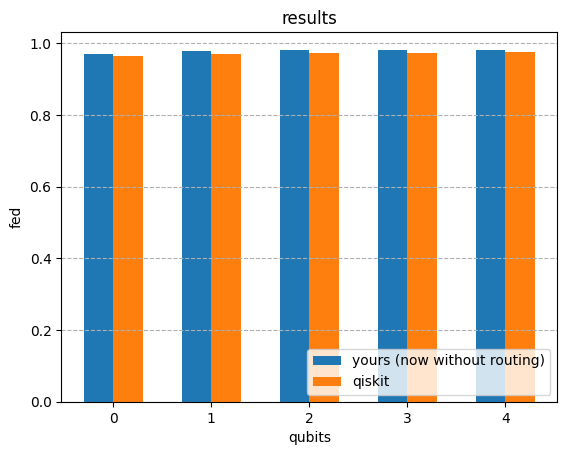

In [16]:
qc = Q_circuit()
qc.load_test(2)
qc.routing()  # 你需要完成的部分
qc.compute_fed()
list1 = sorted(qc.fed_logi_list) # 这个结果是没有routing的逻辑电路结果，由于routing要插入swap，最终结果只会比它低
qc.mpping_by_qiskit()
qc.compute_fed()
list2 = sorted(qc.fed_logi_list) 

labels = [i for i in range(len(list1))]
x = np.arange(len(labels))
width = 0.3  # 每个柱子的宽度
fig, ax = plt.subplots()
ax.bar(x - 0.15, list1, width, label='yours (now without routing)')
ax.bar(x +0.15, list2, width, label='qiskit')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('qubits')
ax.set_ylabel('fed')
ax.set_title('results')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', which='both', axis='y')  # 虚线网格
plt.show()

## 附加任务：含内存的芯片架构编译算法

假设所有量子比特都通过一条总线连接在一个量子内存上，将数据swap进内存可以减少退相干造成的失真，但无法做运算，需要再swap到超导量子比特上。
开发一个算法，尽量利用起内存的优秀量子特性，提高电路的保真度。

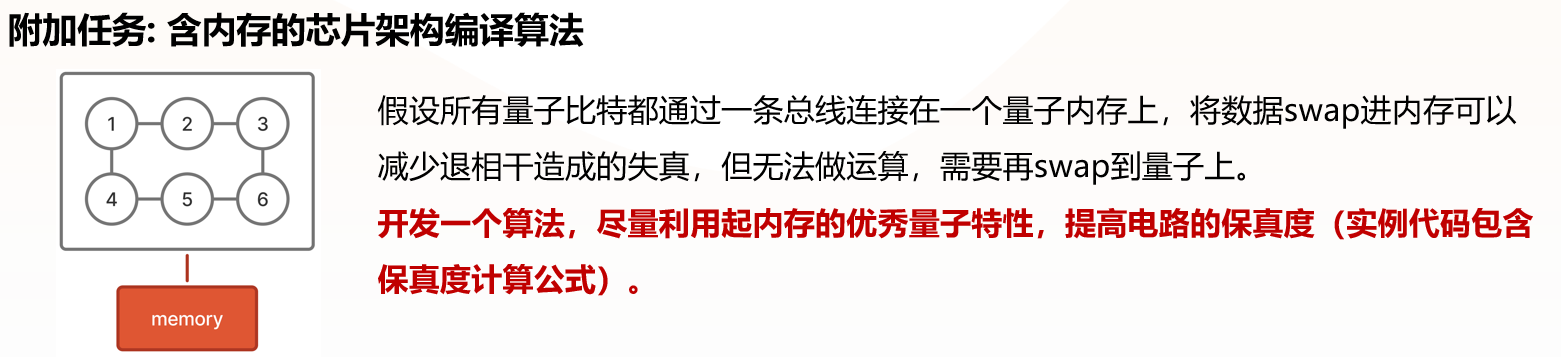

routing_lib.py中留有一些该任务可能会用到的结构和接口，如有需要，请随意另起炉灶。

### 附加任务需要的了解的数据：(CN_Qubits 类)

超导芯片$T_1c$ = 300e3 ns

量子内存$T_1m$ = 7e9 ns

单比特门：时长：30 ns, 保真度：99.98%

双比特门：时长：60 ns, 保真度：99.95%

SWAP门： 时长：120 ns, 保真度：99.85% (99.95%^3)  add_swap_gate可添加该门,有需要请随意修改

内存-比特交换门: 时长：120 ns, 保真度：99.7% add_mem_gate可添加该门,有需要请随意修改

### 保真度计算：

对于给定的超导量子芯片，我们有能量弛豫时间 $T_1c$ ，单比特门保真度 $F_1$ ，双比特门保真度 $F_2$ ，SWAP门保真度 $F_3$电路运行时间 t 。

那么，假设某量子比特在电路运行中共执行了 n 个单比特门， m 个双比特门，x 个SWAP门,运行了时间 t 后结束，那么它的保真度就是：

$$
\text { Fed }_{\text {qubit }}=e^{-t / T_1c} \cdot F_1^n \cdot F_2^m \cdot F_3^x
$$


其实就是把退相干效应和所有门误差相乘。
退相干效应 $e^{-t / T_1}$ 表示在时间 t 内，量子态因能量弛豫（从激发态自发衰变到基态）而 ＂丢失＂的概率。换句话说，这是保留在指定量子态上的概率幅度。

本项目我们忽略相位弛豫 $T_2$ 带来的误差损失。

进一步，当我们考虑量子比特在超导比特上的时间t1, 在量子内存的时间t2, 内存-比特交换门 y个, 内存-比特交换门保真度 $F_4$，那么我们有比特保真度：

$$
\text { Fed }_{\text {qubit }}=e^{-t1 / T_1c} \cdot e^{-t2 / T_1m} \cdot F_1^n \cdot F_2^m \cdot F_3^x \cdot F_4^y
$$

ps：你也可以把单个SWAP当做3个双比特门计算